In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both 1day Adjusted Close Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error

# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_3

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  1995-01-03   1.228913   25967200
1     1  1995-01-04   1.260937   39670400
2     2  1995-01-05   1.244925   18410000
3     3  1995-01-06   1.344999  269155600
4     4  1995-01-09   1.319479   68521600
---
      Item        Date   Adj_Close    Volume
5147  5147  2015-06-12  122.781413  36886200
5148  5148  2015-06-15  122.540040  43988900
5149  5149  2015-06-16  123.196574  31494100
5150  5150  2015-06-17  122.906931  32918100
5151  5151  2015-06-18  123.466910  35407200


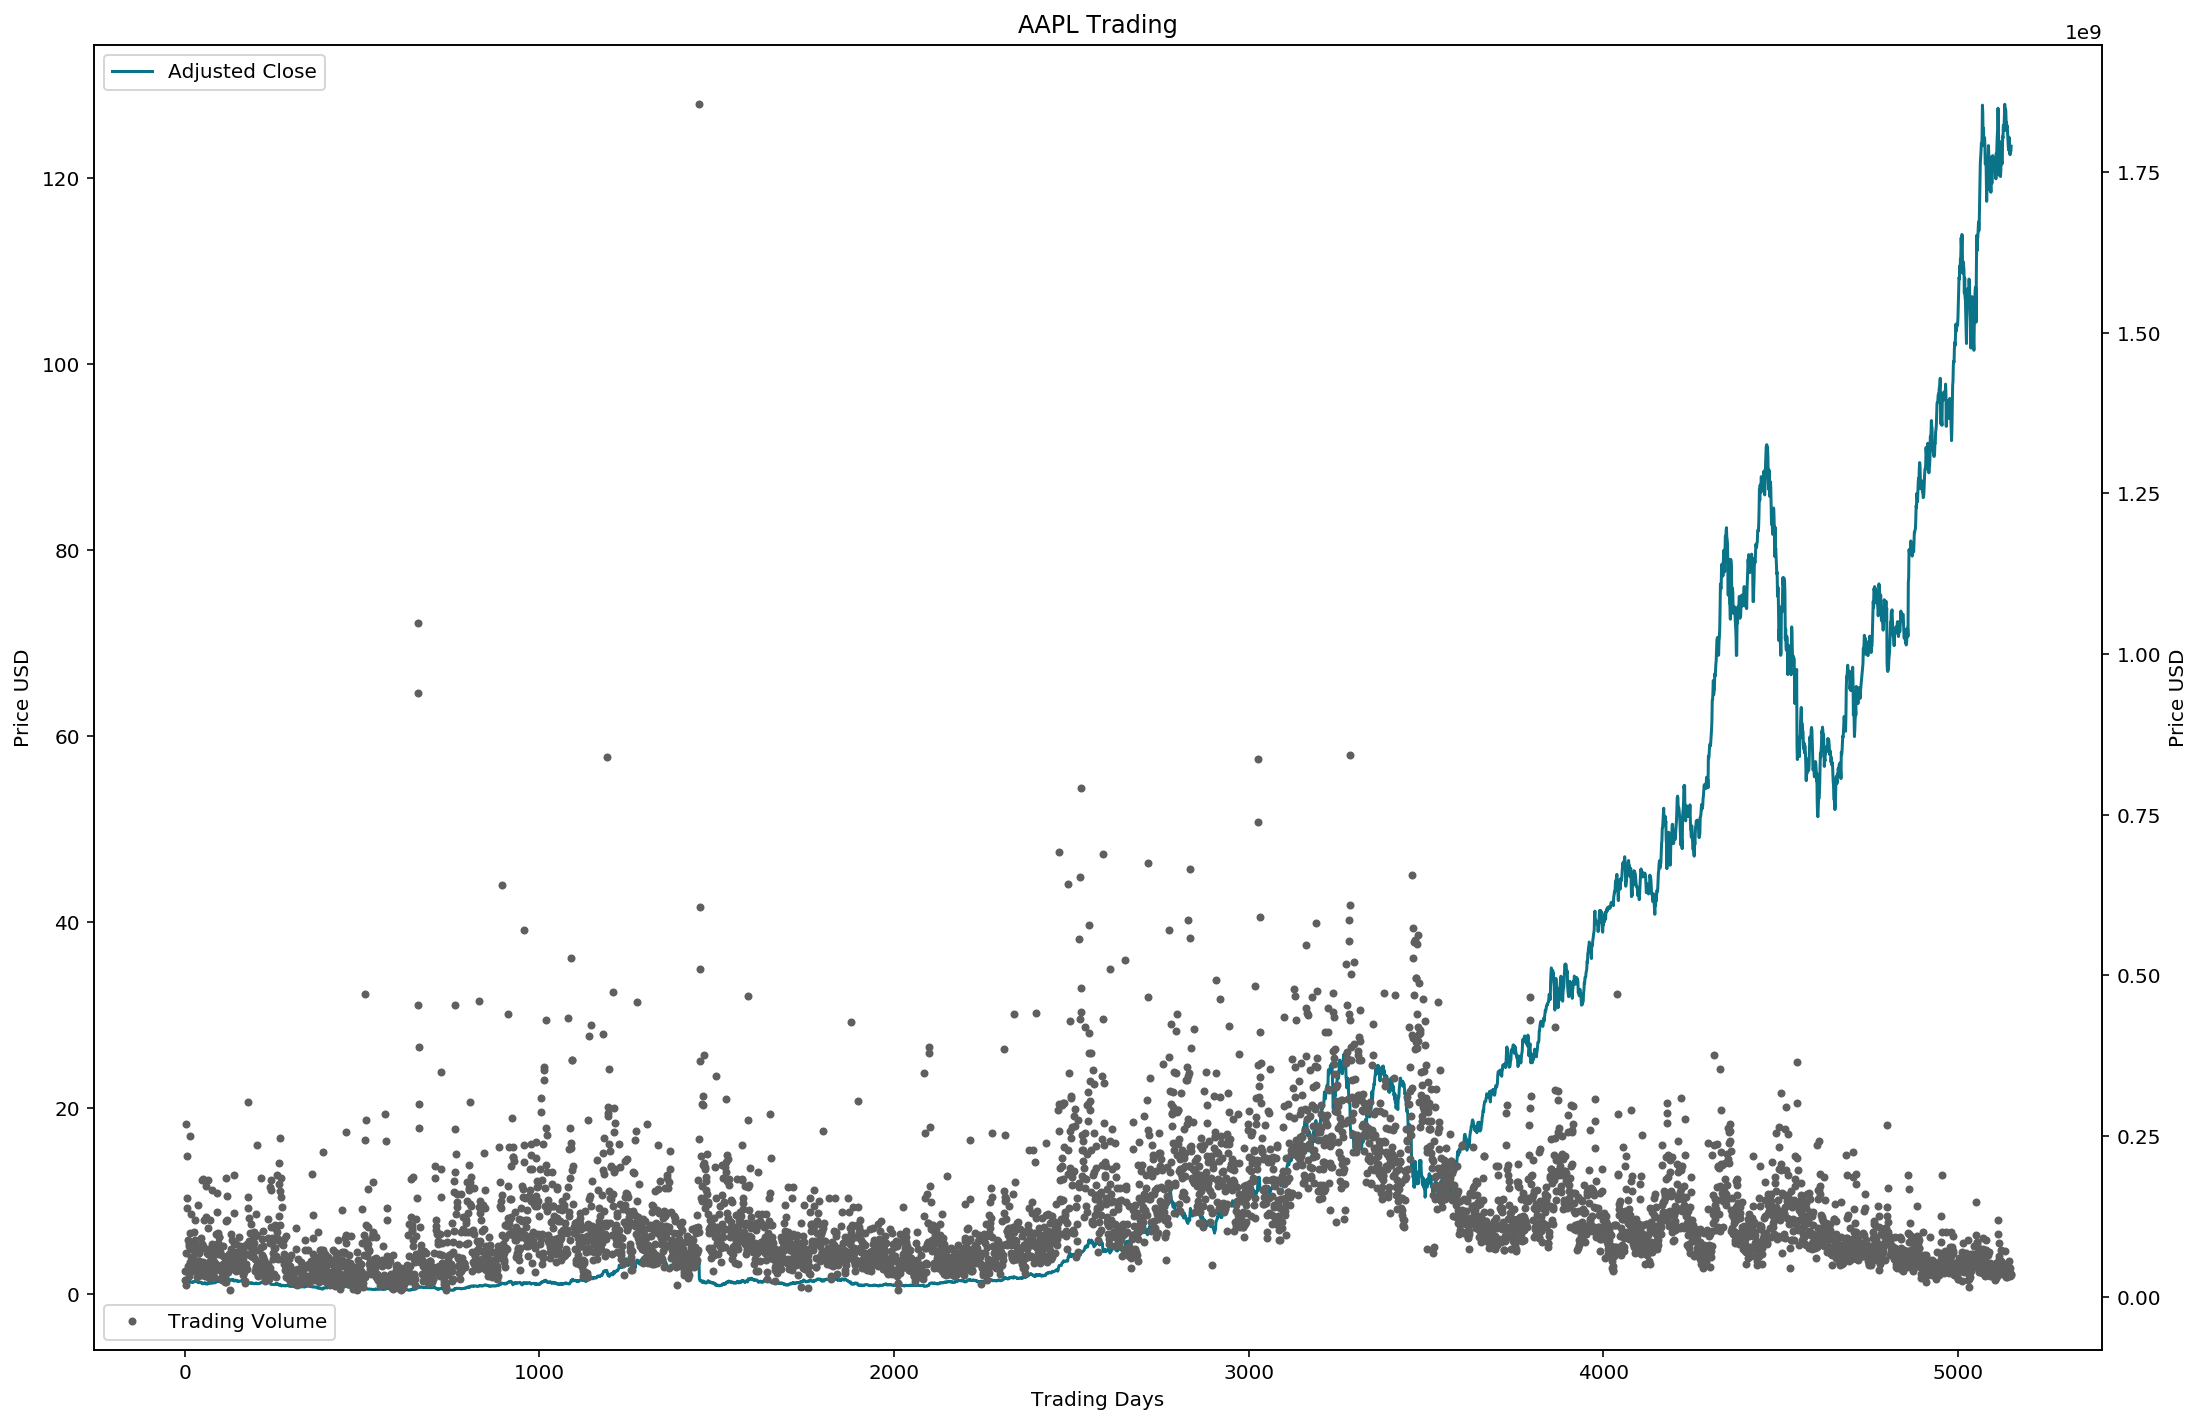

In [4]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append([(row['Item'])])
    vol_all.append([(row['Volume'])])
    close_all.append([(row['Adj_Close'])])
    
pprint(close_all)

[[1.228913],
 [1.260937],
 [1.244925],
 [1.344999],
 [1.319479],
 [1.399039],
 [1.497112],
 [1.45308],
 [1.437068],
 [1.425059],
 [1.441071],
 [1.461085],
 [1.469091],
 [1.365014],
 [1.353005],
 [1.33299],
 [1.312473],
 [1.26494],
 [1.276949],
 [1.2849549999999998],
 [1.292961],
 [1.2849549999999998],
 [1.33299],
 [1.296964],
 [1.296964],
 [1.3069709999999999],
 [1.355007],
 [1.397038],
 [1.401041],
 [1.404898],
 [1.378807],
 [1.366765],
 [1.386835],
 [1.364758],
 [1.31659],
 [1.310569],
 [1.290499],
 [1.252366],
 [1.2282819999999999],
 [1.268422],
 [1.284478],
 [1.284478],
 [1.292506],
 [1.27645],
 [1.230289],
 [1.270429],
 [1.27645],
 [1.268422],
 [1.2242680000000001],
 [1.1239190000000001],
 [1.1239190000000001],
 [1.131946],
 [1.127932],
 [1.131946],
 [1.164058],
 [1.222261],
 [1.192156],
 [1.212226],
 [1.1941629999999999],
 [1.103849],
 [1.103849],
 [1.13596],
 [1.131946],
 [1.139975],
 [1.087793],
 [1.115891],
 [1.1801139999999999],
 [1.1801139999999999],
 [1.1761],
 [1.212226],


In [6]:
# Reshape into t and t+1
look_back = 1
tt_split = (1.0-.315)

X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)
    
pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.00634957]],

       [[ 0.00660065]],

       [[ 0.00647511]],

       ..., 
       [[ 0.08341128]],

       [[ 0.08889649]],

       [[ 0.09278693]]])
--
array([[ 0.00660065],
       [ 0.00647511],
       [ 0.00725971],
       ..., 
       [ 0.08889649],
       [ 0.09278693],
       [ 0.09120231]])


In [7]:
pprint(np.shape(X_close_train))
pprint(np.shape(X_close_test))

pprint(X_close_train)

pprint(y_close_train)

(3528, 1, 1)
(1622, 1, 1)
array([[[ 0.00634957]],

       [[ 0.00660065]],

       [[ 0.00647511]],

       ..., 
       [[ 0.08341128]],

       [[ 0.08889649]],

       [[ 0.09278693]]])
array([[ 0.00660065],
       [ 0.00647511],
       [ 0.00725971],
       ..., 
       [ 0.08889649],
       [ 0.09278693],
       [ 0.09120231]])


In [8]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 5 # 200
n_nodes = [128]

# Create two branches of LSTM model

# Create LSTM Adjusted Close network - 1 day tracker 
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.134787797928


In [9]:
# Format inputs
train_inputs = X_close_train

# Train the model
model.fit(train_inputs, 
                y_close_train, 
                nb_epoch=epochs, 
                batch_size=batch_size, 
                verbose=2,
                validation_split=0.05
                )

Train on 3351 samples, validate on 177 samples
Epoch 1/5
11s - loss: 9.9788e-05 - val_loss: 2.2377e-05
Epoch 2/5
11s - loss: 5.9661e-06 - val_loss: 2.4679e-05
Epoch 3/5
11s - loss: 5.9288e-06 - val_loss: 2.5465e-05
Epoch 4/5
11s - loss: 5.5099e-06 - val_loss: 3.0001e-05
Epoch 5/5
10s - loss: 5.4724e-06 - val_loss: 4.2815e-05


In [10]:
# Format inputs
test_inputs = X_close_test

# Generate predictions for training
testPredict = model.predict(test_inputs, batch_size=batch_size)
#testPredict = util.predict_sequences(model, test_inputs)

pprint(testPredict)
print(np.shape(X_close_test))

array([[ 0.09470803],
       [ 0.09264643],
       [ 0.09437979],
       ..., 
       [ 0.95319569],
       [ 0.95142692],
       [ 0.95623618]], dtype=float32)
(1622, 1, 1)


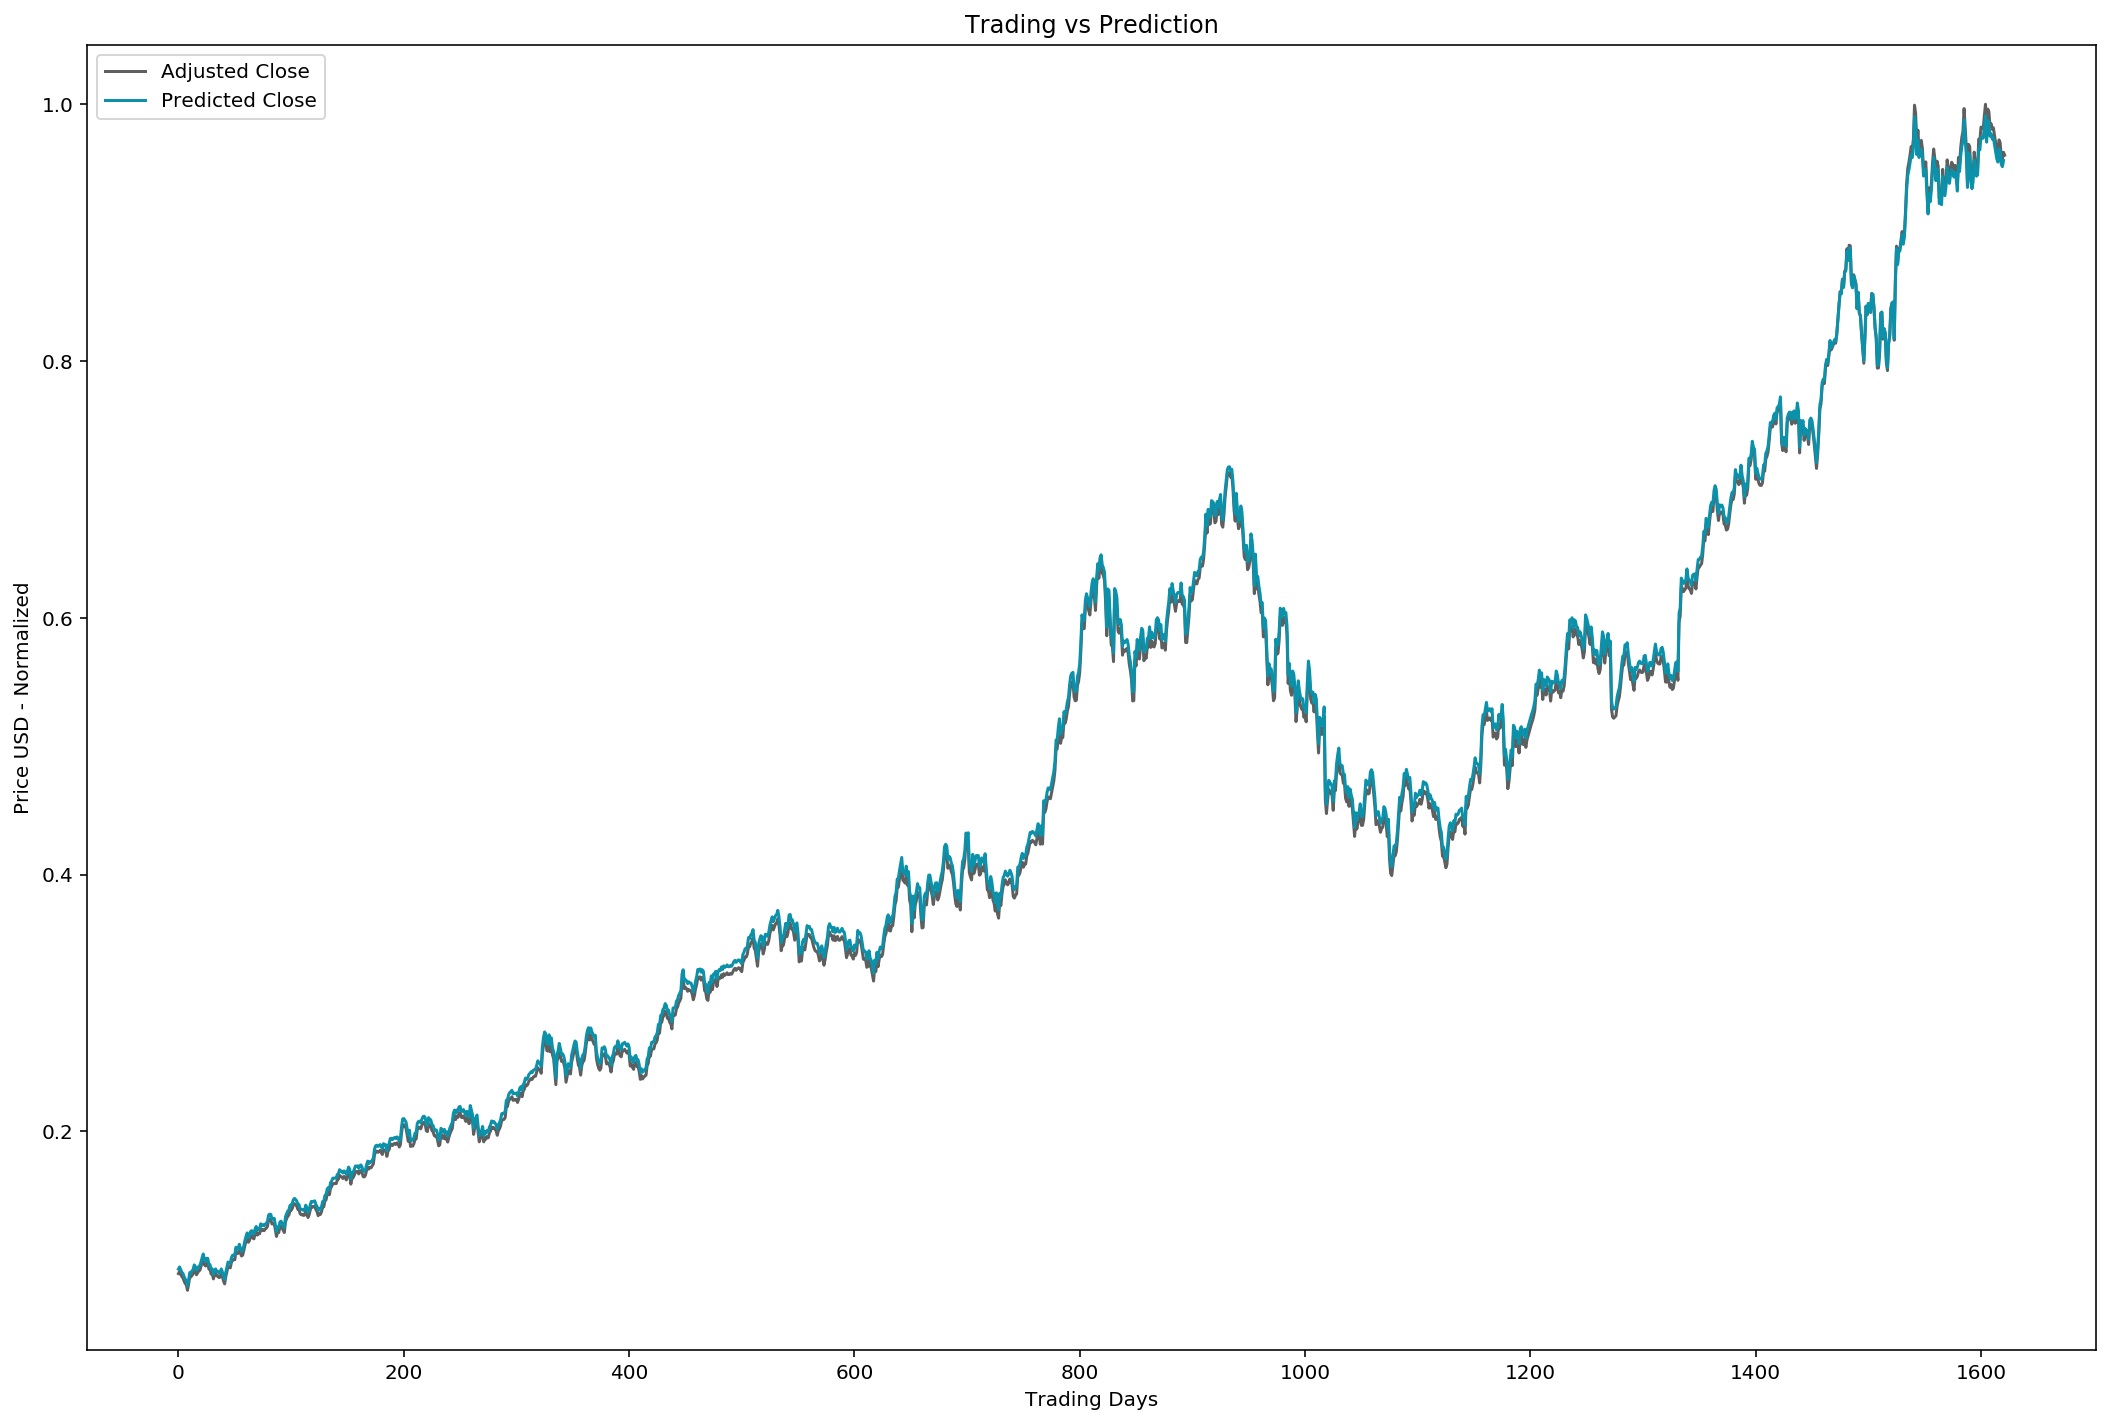

In [11]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict[1:], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [12]:
# The mean squared error
testScore = model.evaluate(test_inputs, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

# Calculate the stock price delta in $
true_delta = testScore*(close_bounds[1]-close_bounds[0])
print('Delta Price: %.6f - RMSE * Adjusted Close Range' % true_delta)

Test Score: 0.000095 MSE (0.009769 RMSE)
Delta Price: 0.012173 - RMSE * Adjusted Close Range


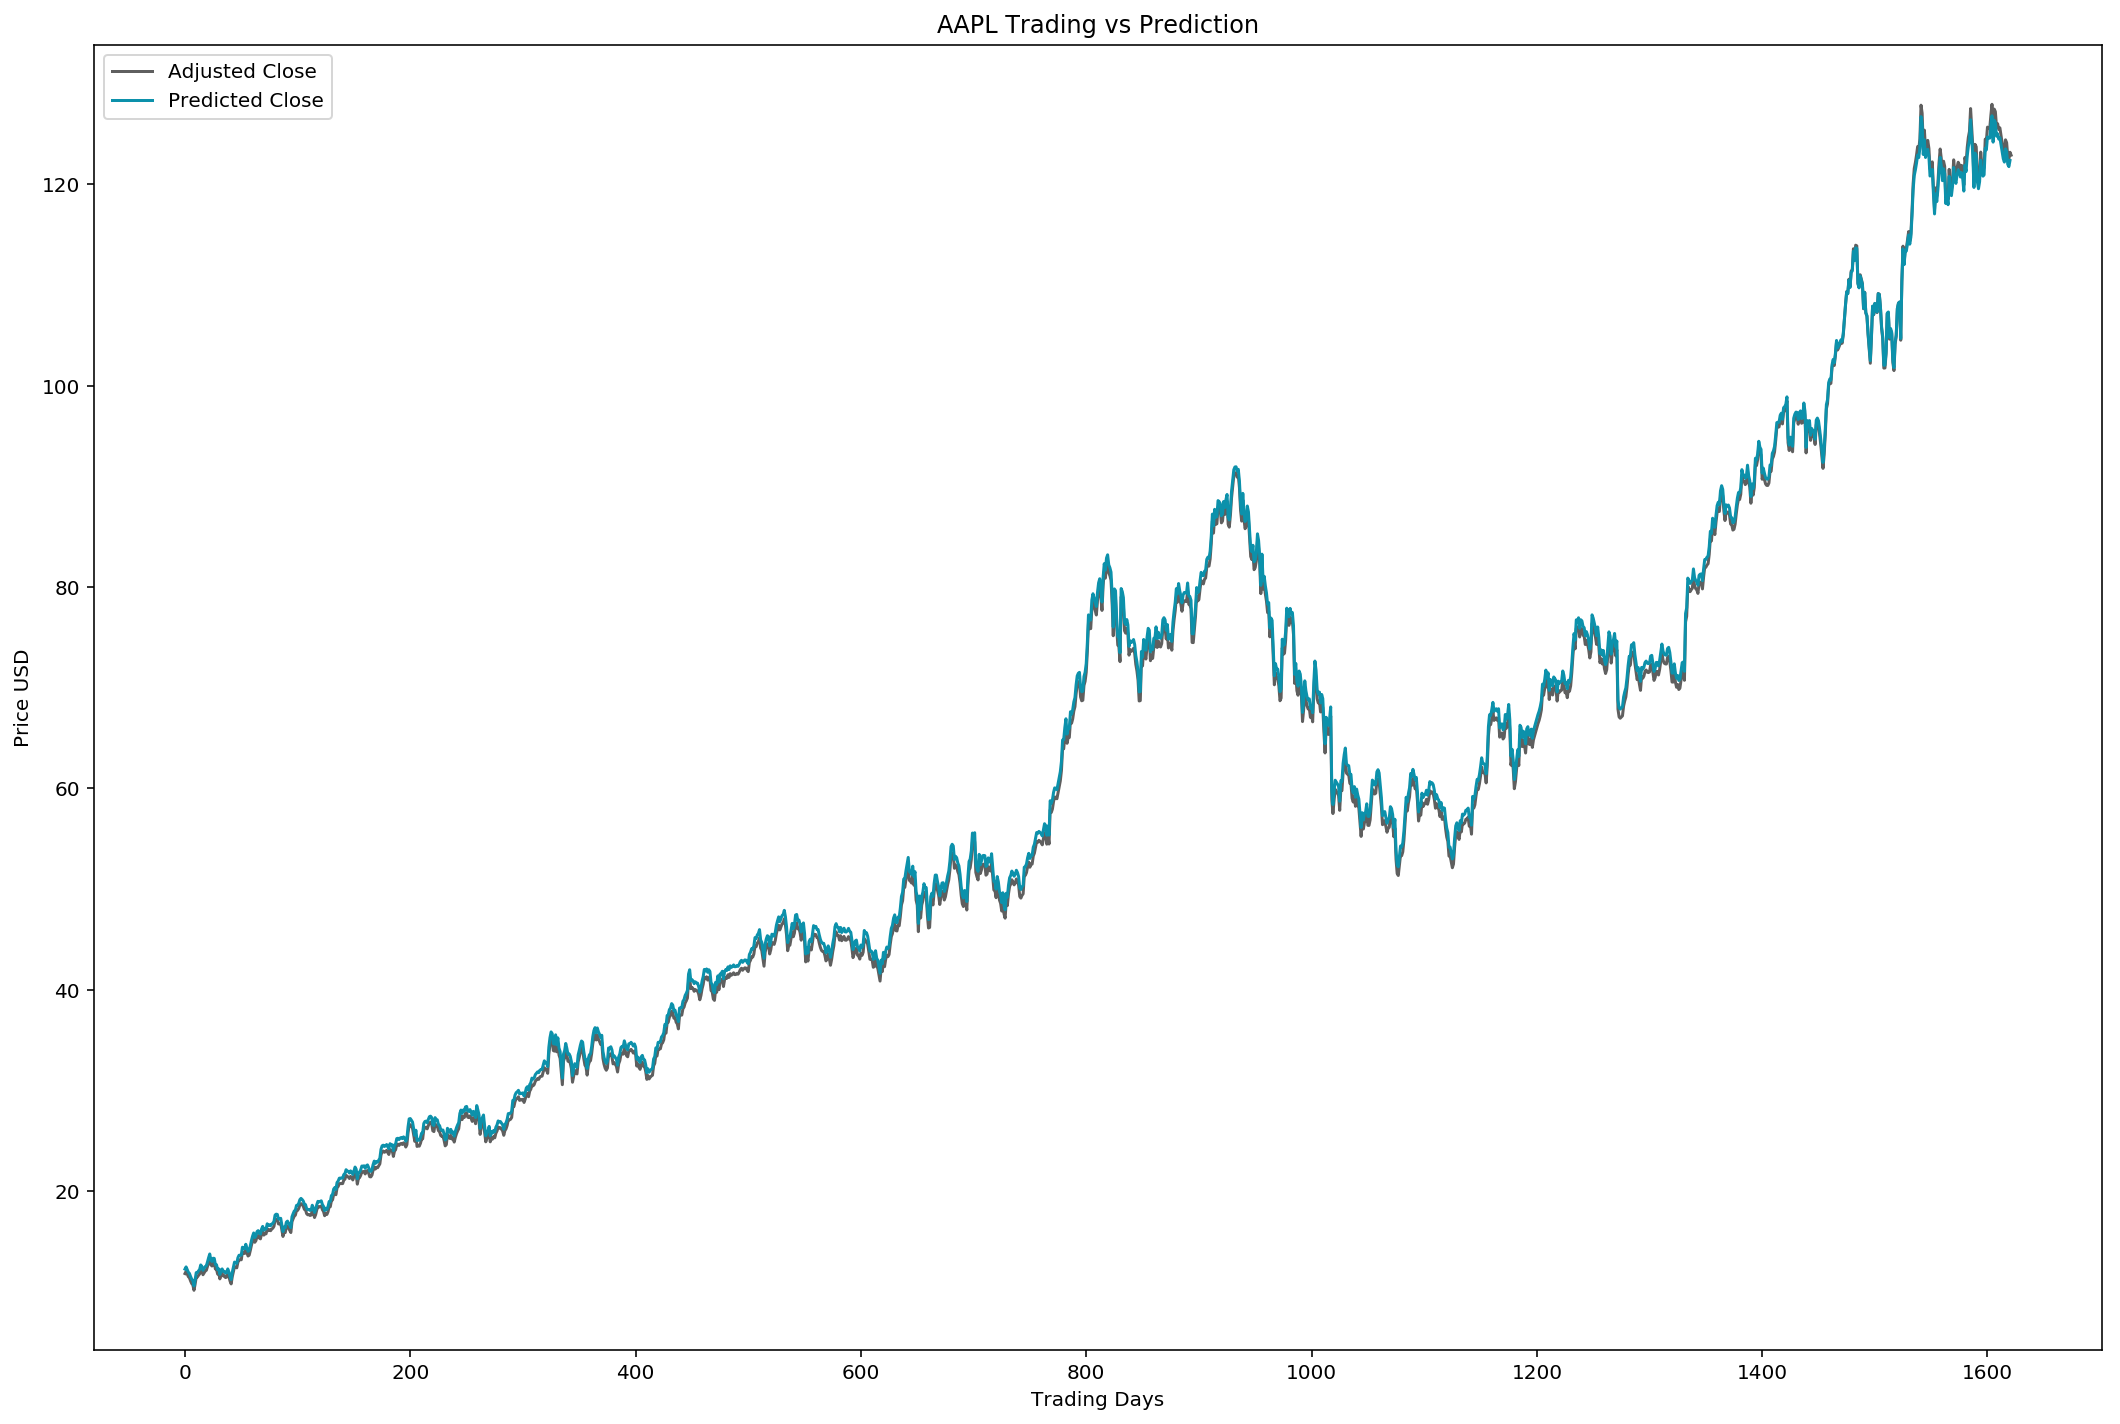

In [13]:
# Plot the predictions
#close_plot = close_all[-ya_close_test.shape[0]:]

close_seq = np.array(y_close_test)
pred_seq = np.array(testPredict)

#pprint(pred_seq)
close_seq_plot, r = util.scale_range(y_close_test, input_range=[0.0,1.0], target_range=close_bounds)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(close_seq_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[1:], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

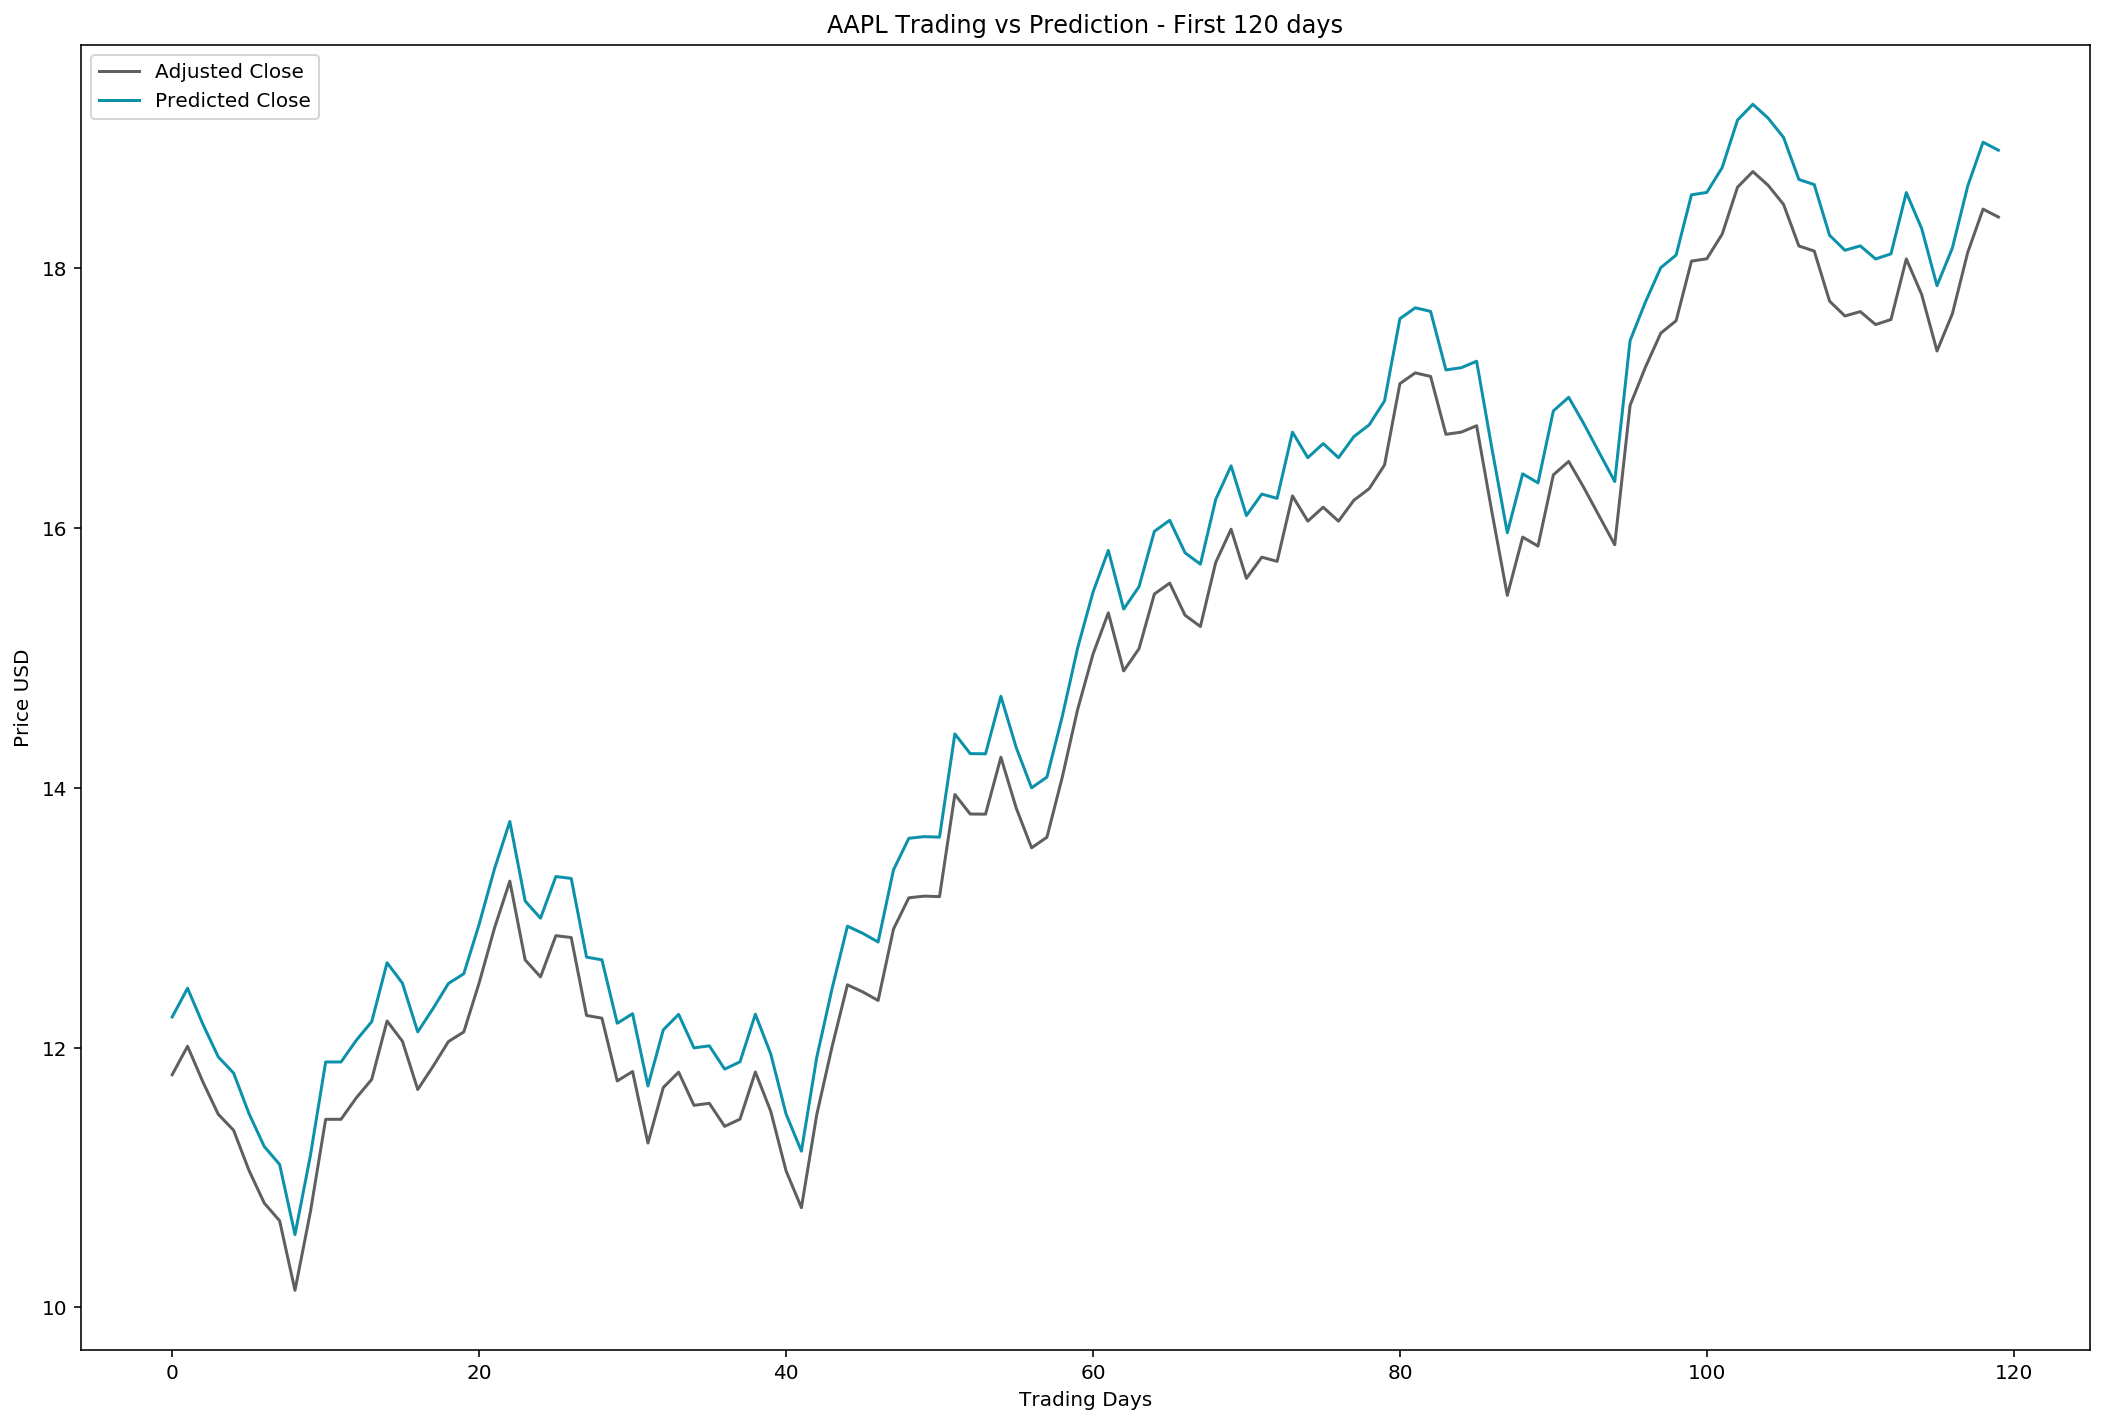

In [14]:
# Plot the predictions first 120 days (6 months of trading)
subspan = 120
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(close_seq_plot[:subspan],'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[1:subspan+1], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction - First 120 days')
ax.legend(loc='upper left')

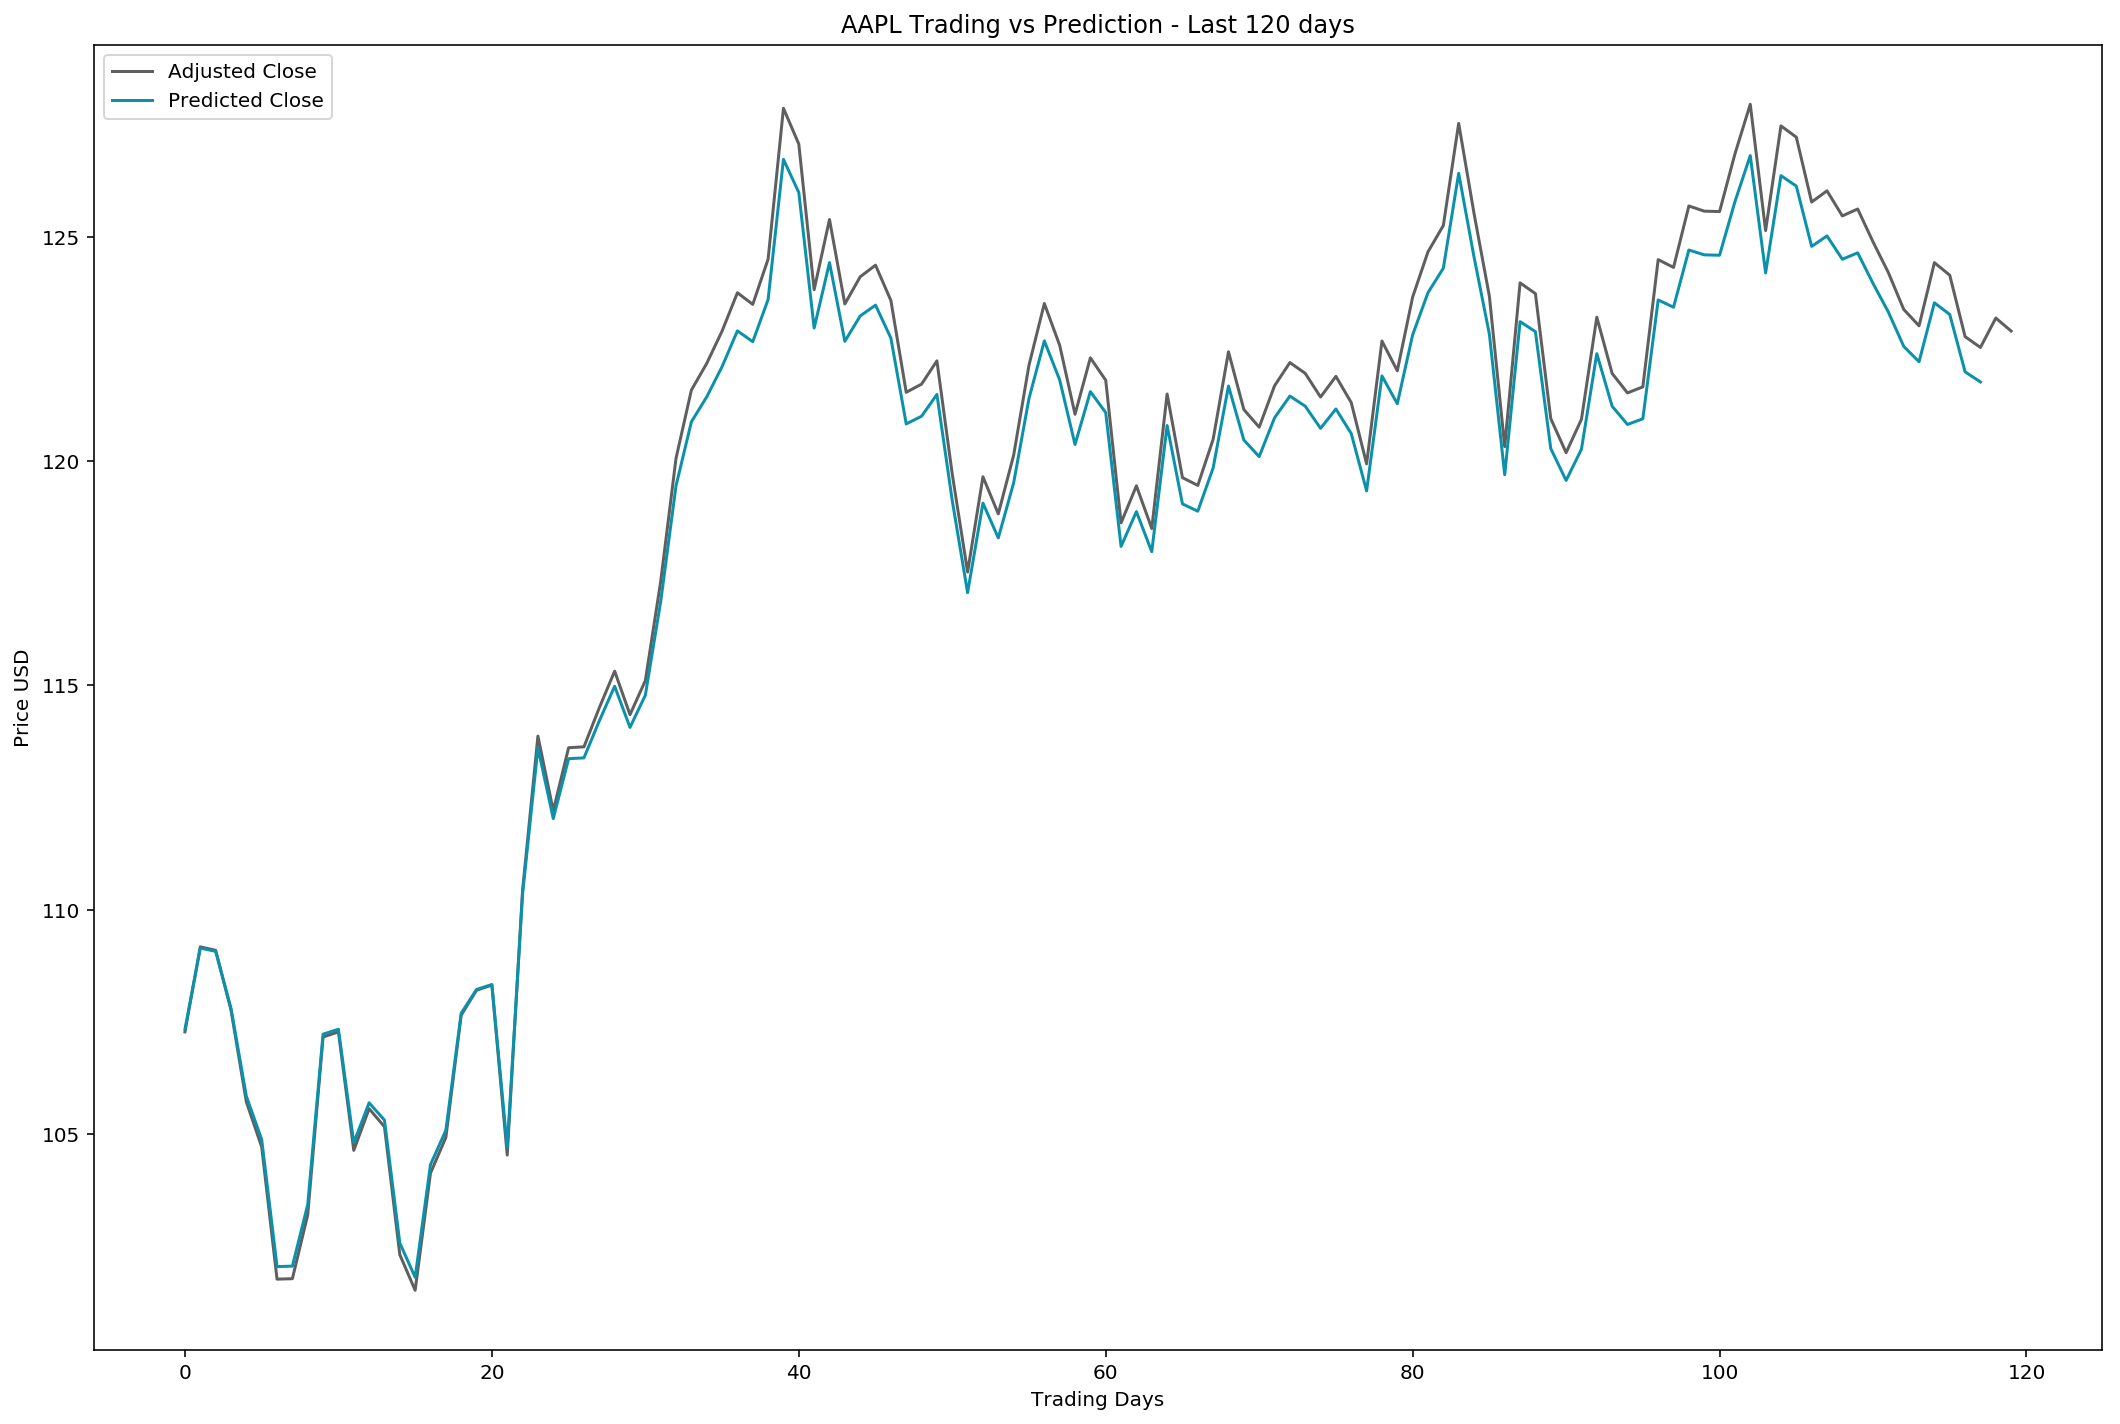

In [15]:
# Plot the predictions last 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

# Offset predictions by one day to align prediction and actual 
plt.plot(close_seq_plot[-subspan:],'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot[-(subspan-1):-1], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction - Last 120 days')
ax.legend(loc='upper left')

In [16]:
# Trading Algorithm

# Create a dataframe for stock data
trades_df = pd.DataFrame(columns=('Price','Prediction','PredDelta','State','Shares','IncShares','StockValue','Cash','Folio','IncSum','Performance'))
# Create variable for stock ownership
own = True

# Loop through trading days
for i in range(0, len(preds_seq_plot)-1):
    # Until the final day in sequence
    if i < len(preds_seq_plot)-2:
        # For first day, initiate trading
        if i == 0:
            start_price = close_seq_plot[0][0]
            trades_df.loc[i,'Price'] = start_price
            trades_df.loc[i,'Folio'] = 1000.0
            trades_df.loc[i,'State'] = 'Buy'
            trades_df.loc[i,'Shares'] = math.floor(trades_df.loc[i,'Folio']/start_price)
            trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Shares']*start_price
            trades_df.loc[i,'Cash'] = trades_df.loc[i,'Folio']-trades_df.loc[i,'StockValue'] 
            trades_df.loc[i,'PredDelta'] = 0.0
            trades_df.loc[i,'IncSum'] = start_price
            trades_df.loc[i,'IncShares'] = trades_df.loc[i,'Shares']
            buy_price = start_price
            own = True
        # Otherwise, it's the end of the trading day and we decide on trade executed just after close
        else:
            # Get yesterday's closing price
            price_yest = close_seq_plot[i-1][0]
            # Get today's closing price
            price_today = close_seq_plot[i][0]
            
            # quick calc for sum of increase
            if price_today>price_yest:
                trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']+price_today-price_yest
            else:
                trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']
            
            # Get todays's prediction
            pred_today = preds_seq_plot[i+1][0]
            # Get tomorrow's prediction
            pred_tomorrow = preds_seq_plot[i+2][0]
            # Get delta price
            pred_delta = pred_tomorrow-pred_today
            # Store the price
            trades_df.loc[i,'Price'] = price_today
            # Store the prediction
            trades_df.loc[i,'Prediction'] = pred_tomorrow
            # Store prediction delta
            trades_df.loc[i,'PredDelta'] = pred_delta

            # If the stock is currently owned
            if own == True:    
                # If the projection is positive
                if pred_delta > 0:
                    # Hold the stock
                    trades_df.loc[i,'State'] = 'Hold'
                    trades_df.loc[i,'Shares'] = trades_df.loc[i-1,'Shares']
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']
                    own = True
                else:
                    # Sell the stock
                    trades_df.loc[i,'State'] = 'Sell'
                    trades_df.loc[i,'Shares'] = 0.0
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']+(trades_df.loc[i-1,'Shares']*price_today)
                    own = False
            # If the stock is not owned
            else:
                # If the projection is positive
                if pred_delta > 0:
                    # Buy the stock
                    trades_df.loc[i,'State'] = 'Buy'
                    # Store number of shares (cash/currentprice)
                    trades_df.loc[i,'Shares'] = math.floor(trades_df.loc[i-1,'Cash']/price_today)
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']-(trades_df.loc[i,'Shares']*price_today)
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i,'Shares']
                    own = True
                else:
                    # Set the state to pass on trading
                    trades_df.loc[i,'State'] = 'Pass'
                    # Update the number of shares to yesterdays
                    trades_df.loc[i,'Shares'] = 0.0
                    trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
                    trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']
                    own = False
            # Update Folio and Stock Value
            trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Shares']*price_today
            trades_df.loc[i,'Folio'] =trades_df.loc[i,'StockValue']+trades_df.loc[i,'Cash']

    else:
        # Update last day since there aren't any more predictions
        trades_df.loc[i,'Price'] = close_seq_plot[i][0]
        trades_df.loc[i,'Folio'] = trades_df.loc[i-1,'Folio']
        trades_df.loc[i,'Shares'] = trades_df.loc[i-1,'Shares']
        trades_df.loc[i,'StockValue'] = trades_df.loc[i,'Price']*trades_df.loc[i,'Shares']
        trades_df.loc[i,'State'] = trades_df.loc[i-1,'State']
        trades_df.loc[i,'IncShares'] = trades_df.loc[i-1,'IncShares']
        trades_df.loc[i,'IncSum'] = trades_df.loc[i-1,'IncSum']
        trades_df.loc[i,'Cash'] = trades_df.loc[i-1,'Cash']

trades_df['Performance'] = trades_df.loc[:,'Folio']/trades_df.loc[0,'Folio']
trades_df['NoLossMarketValue']=trades_df.loc[:,'IncSum']*trades_df.loc[0,'Shares']+trades_df.loc[0,'Cash']
trades_df['NoLossMarketPerform']=trades_df.loc[:,'NoLossMarketValue']/trades_df.loc[0,'NoLossMarketValue']
trades_df['MarketOpt']=trades_df.loc[:,'IncShares']*trades_df.loc[:,'IncSum']+trades_df.loc[0,'Cash']
trades_df['MarketOptPerform']=trades_df.loc[:,'MarketOpt']/trades_df.loc[0,'MarketOpt']
trades_df['InactiveValue']=trades_df.loc[0,'IncShares']*trades_df['Price']+trades_df.loc[0,'Cash']
trades_df['InactivePerform']=trades_df.loc[:,'InactiveValue']/trades_df.loc[0,'InactiveValue']

#close_seq_plot
#preds_seq_plot

pprint(trades_df)
trades_df.to_csv('logs/Study12-'+base_ticker+'.csv')

        Price Prediction  PredDelta State  Shares IncShares   StockValue  \
0     11.7912        NaN          0   Buy      84        84      990.462   
1     12.0102    12.1796  -0.277337  Sell       0        84            0   
2     11.7355    11.9284  -0.251157  Pass       0        84            0   
3     11.4868    11.8041  -0.124264  Pass       0        84            0   
4     11.3637    11.4929  -0.311292  Pass       0        84            0   
5     11.0553    11.2378  -0.255026  Pass       0        84            0   
6     10.8027    11.1005  -0.137314  Pass       0        84            0   
7     10.6666    10.5605  -0.540044  Pass       0        84            0   
8     10.1316    11.1659   0.605432   Buy     100       100      1013.16   
9     10.7314    11.8892   0.723269  Hold     100       100      1073.14   
10    11.4479    11.8892          0  Sell       0       100            0   
11    11.4479    12.0566   0.167435   Buy     100       100      1144.79   
12    11.613

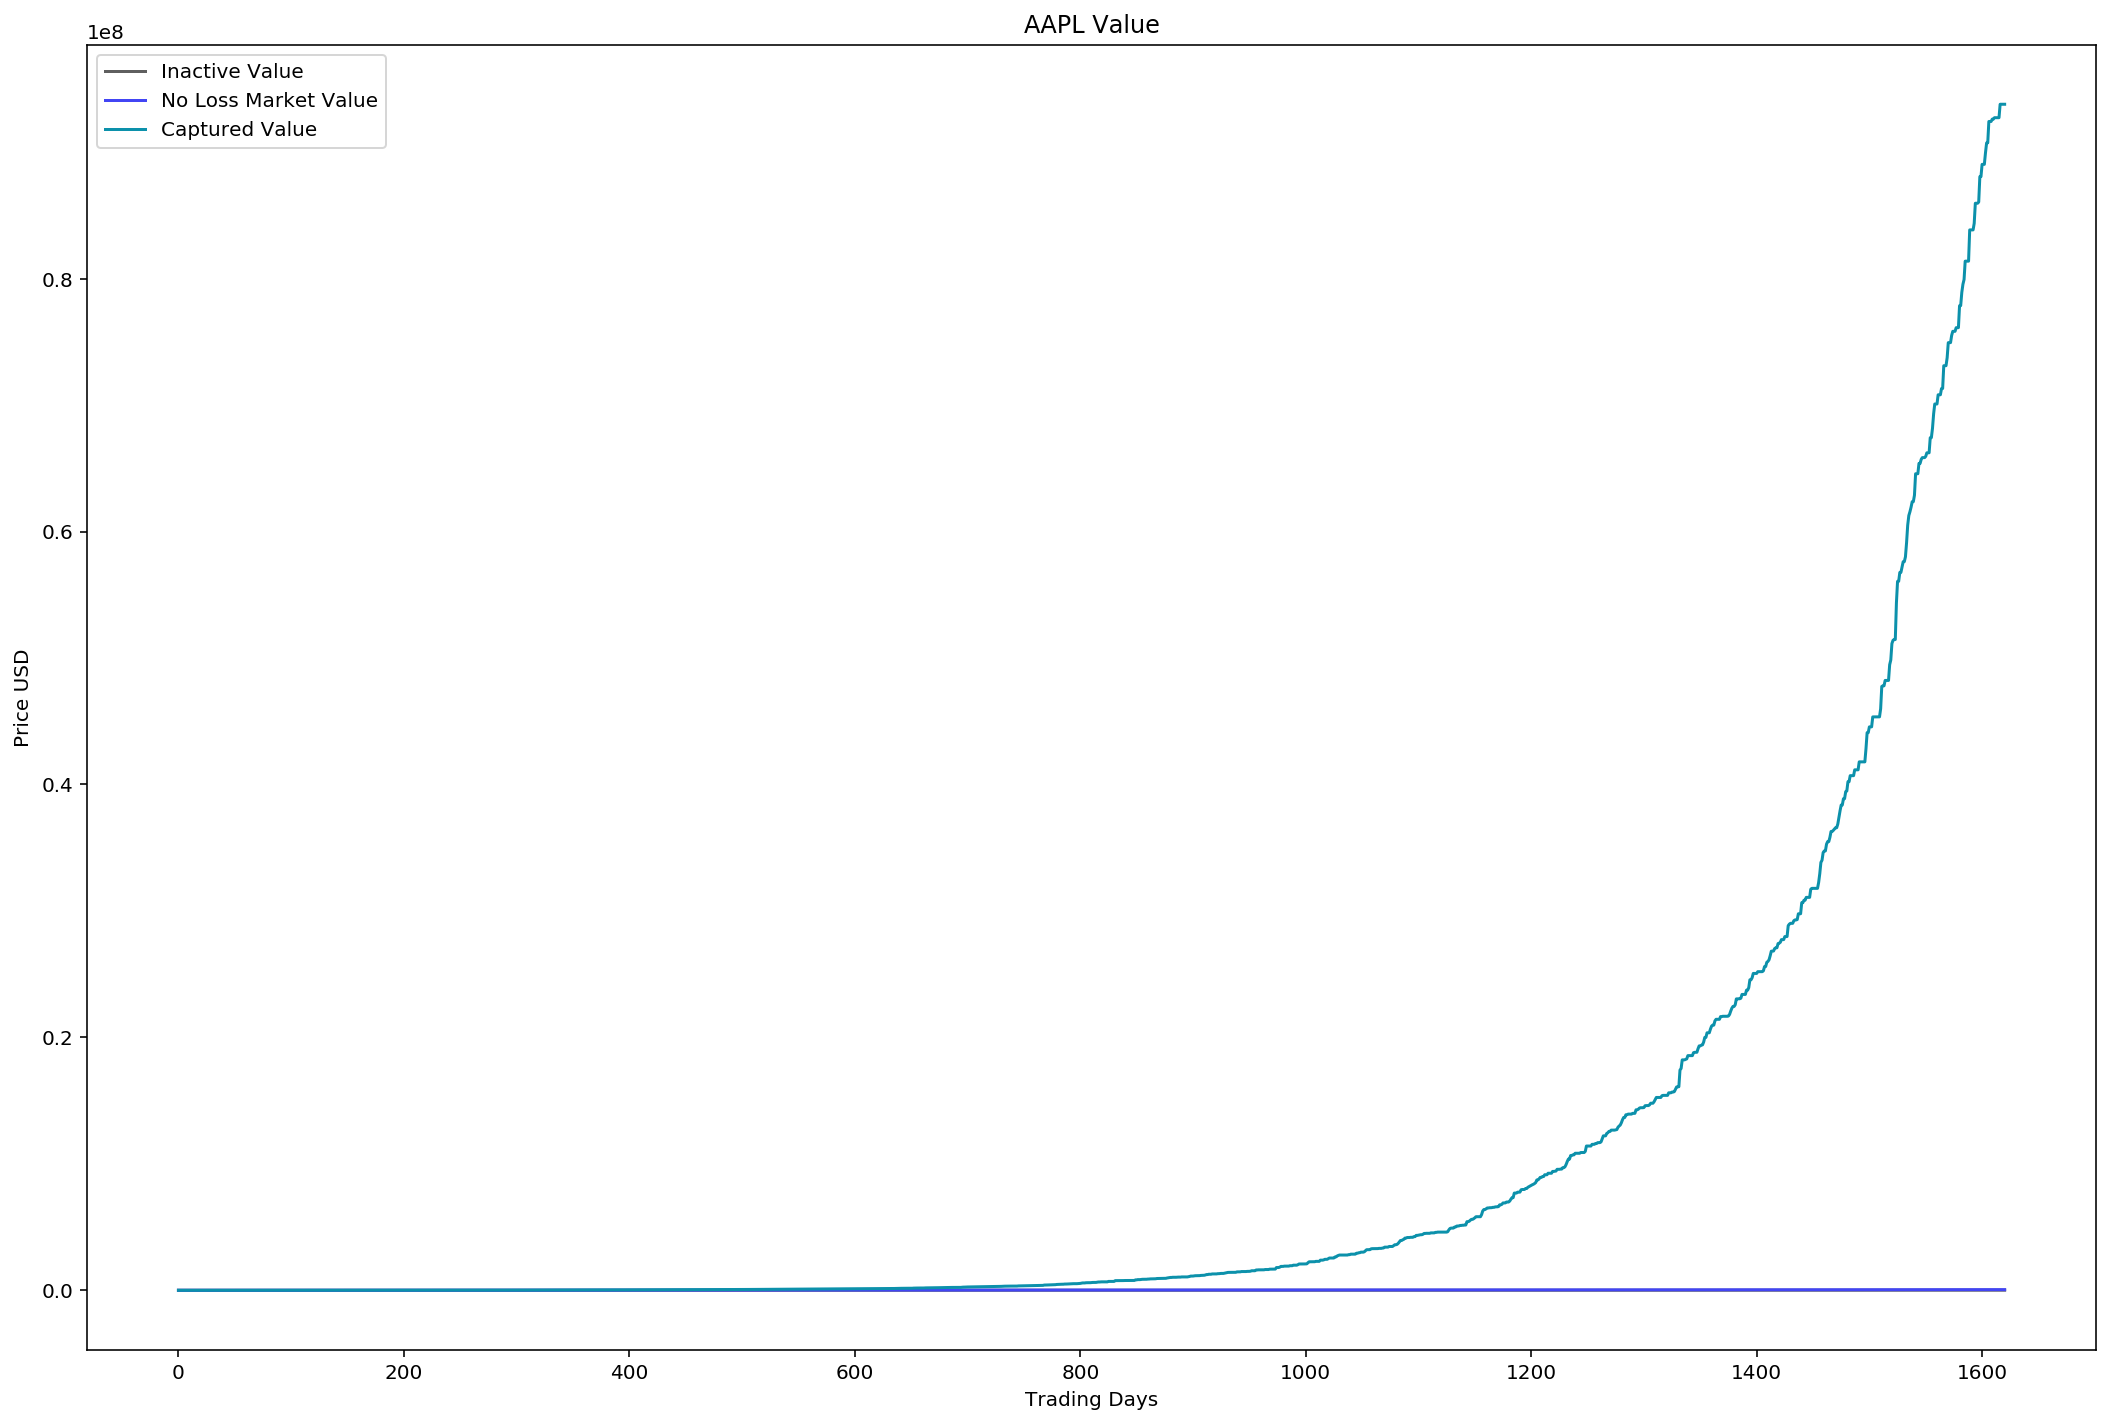

In [17]:
# Plot the stock price and captured value 

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[:,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
#plt.plot(trades_df.loc[:,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value')
ax.legend(loc='upper left')

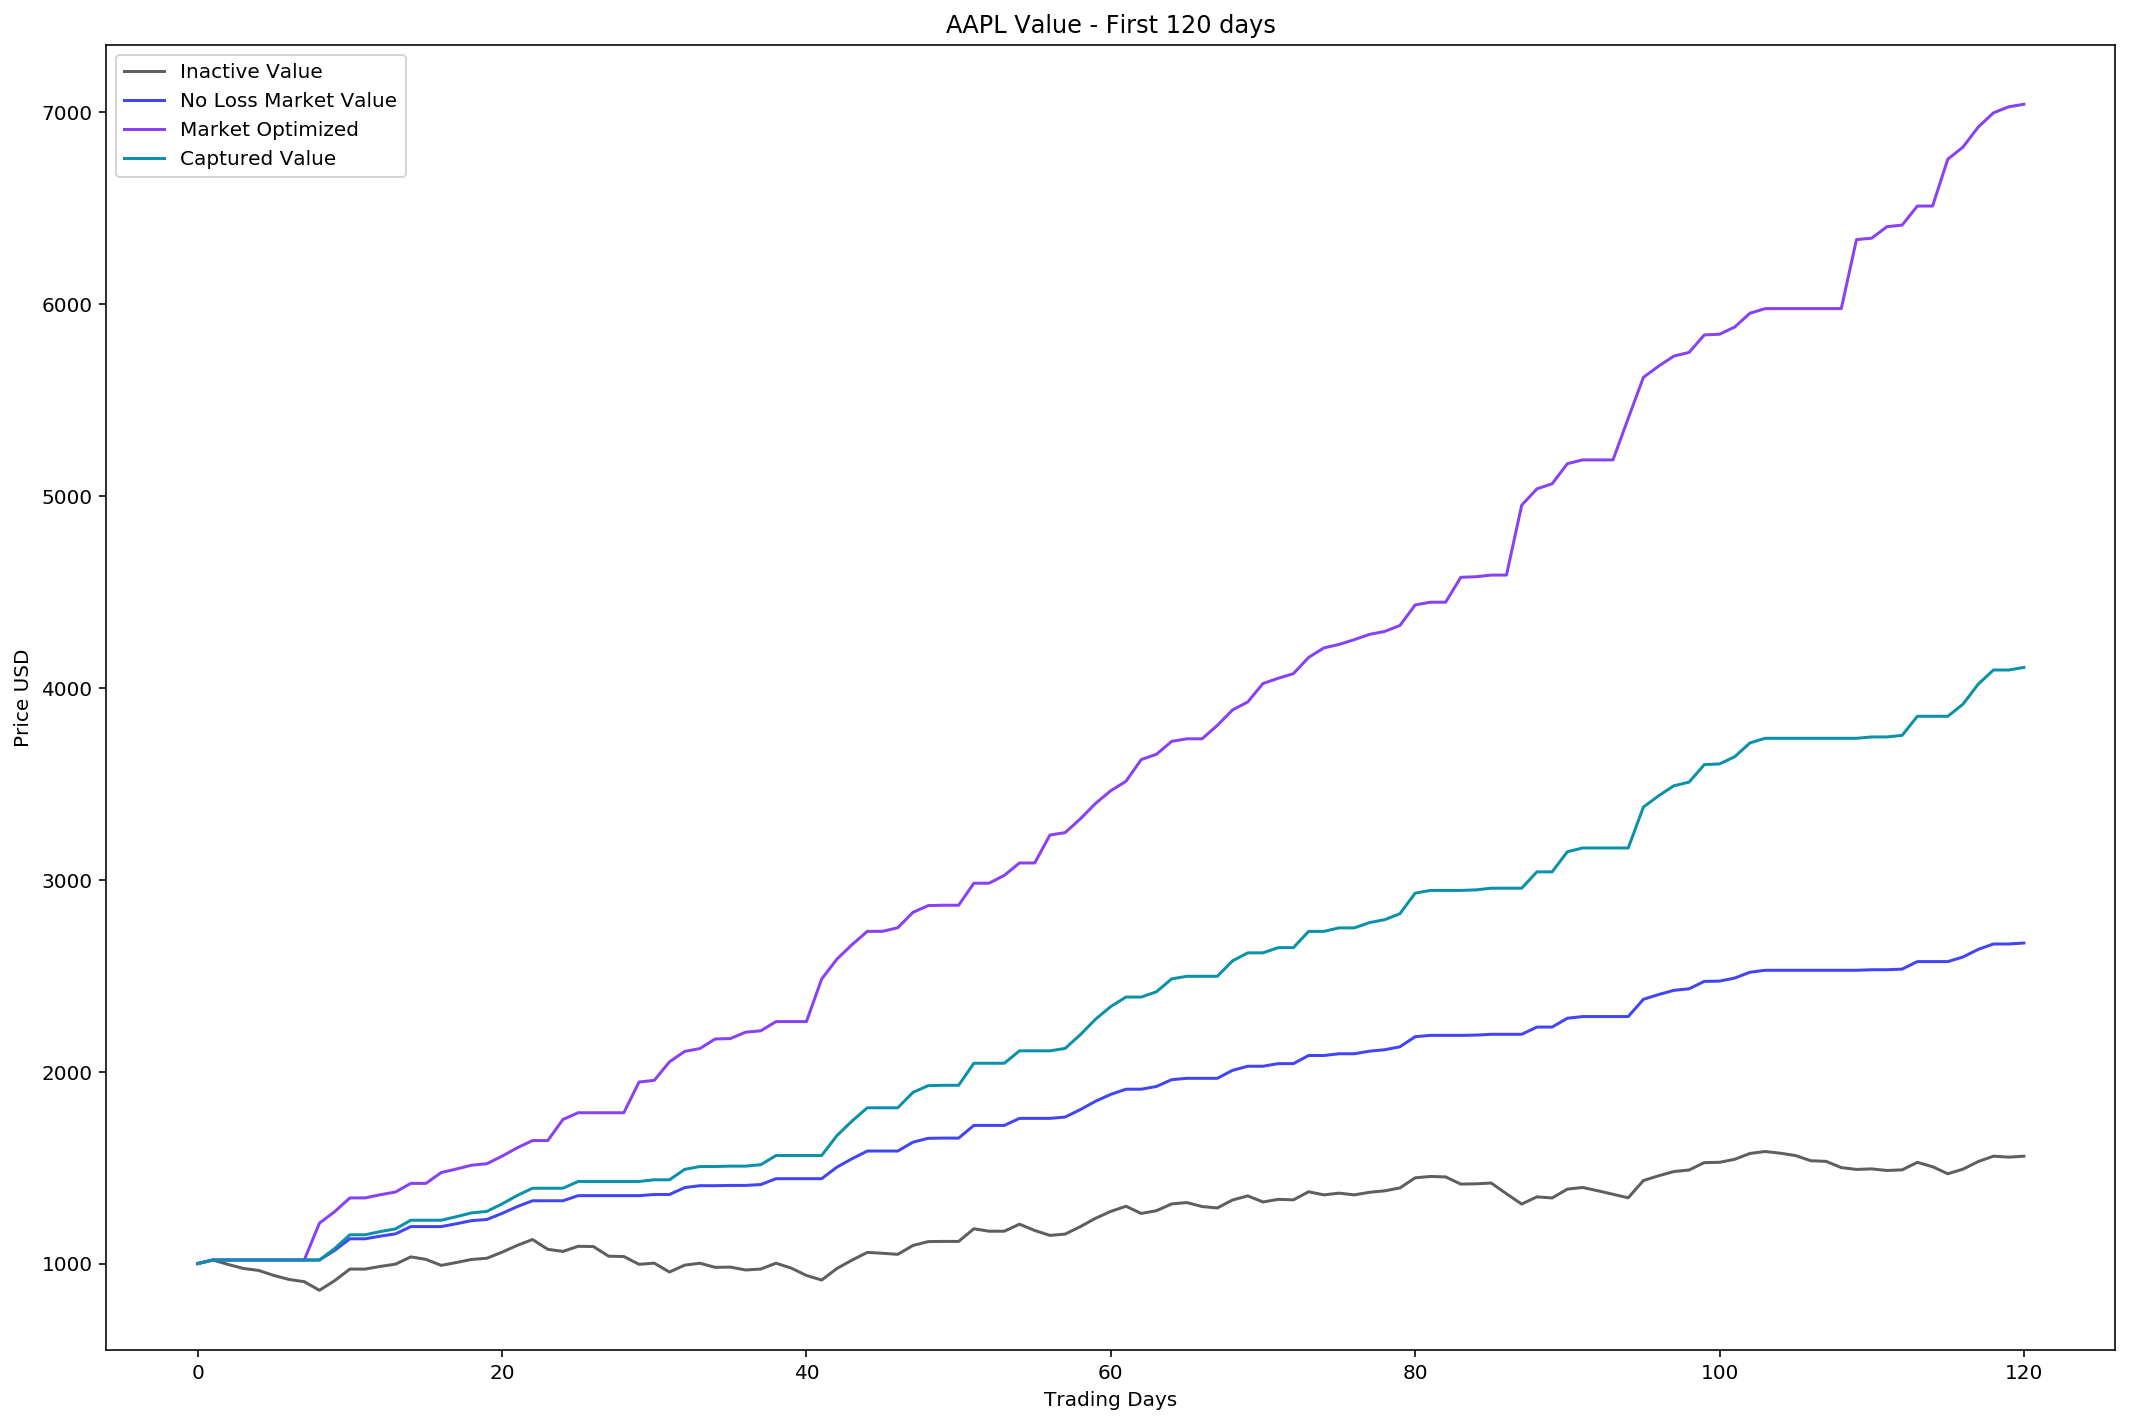

In [18]:
# Plot the stock price and captured value first 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:120,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[:120,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
plt.plot(trades_df.loc[:120,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:120,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value - First 120 days')
ax.legend(loc='upper left')

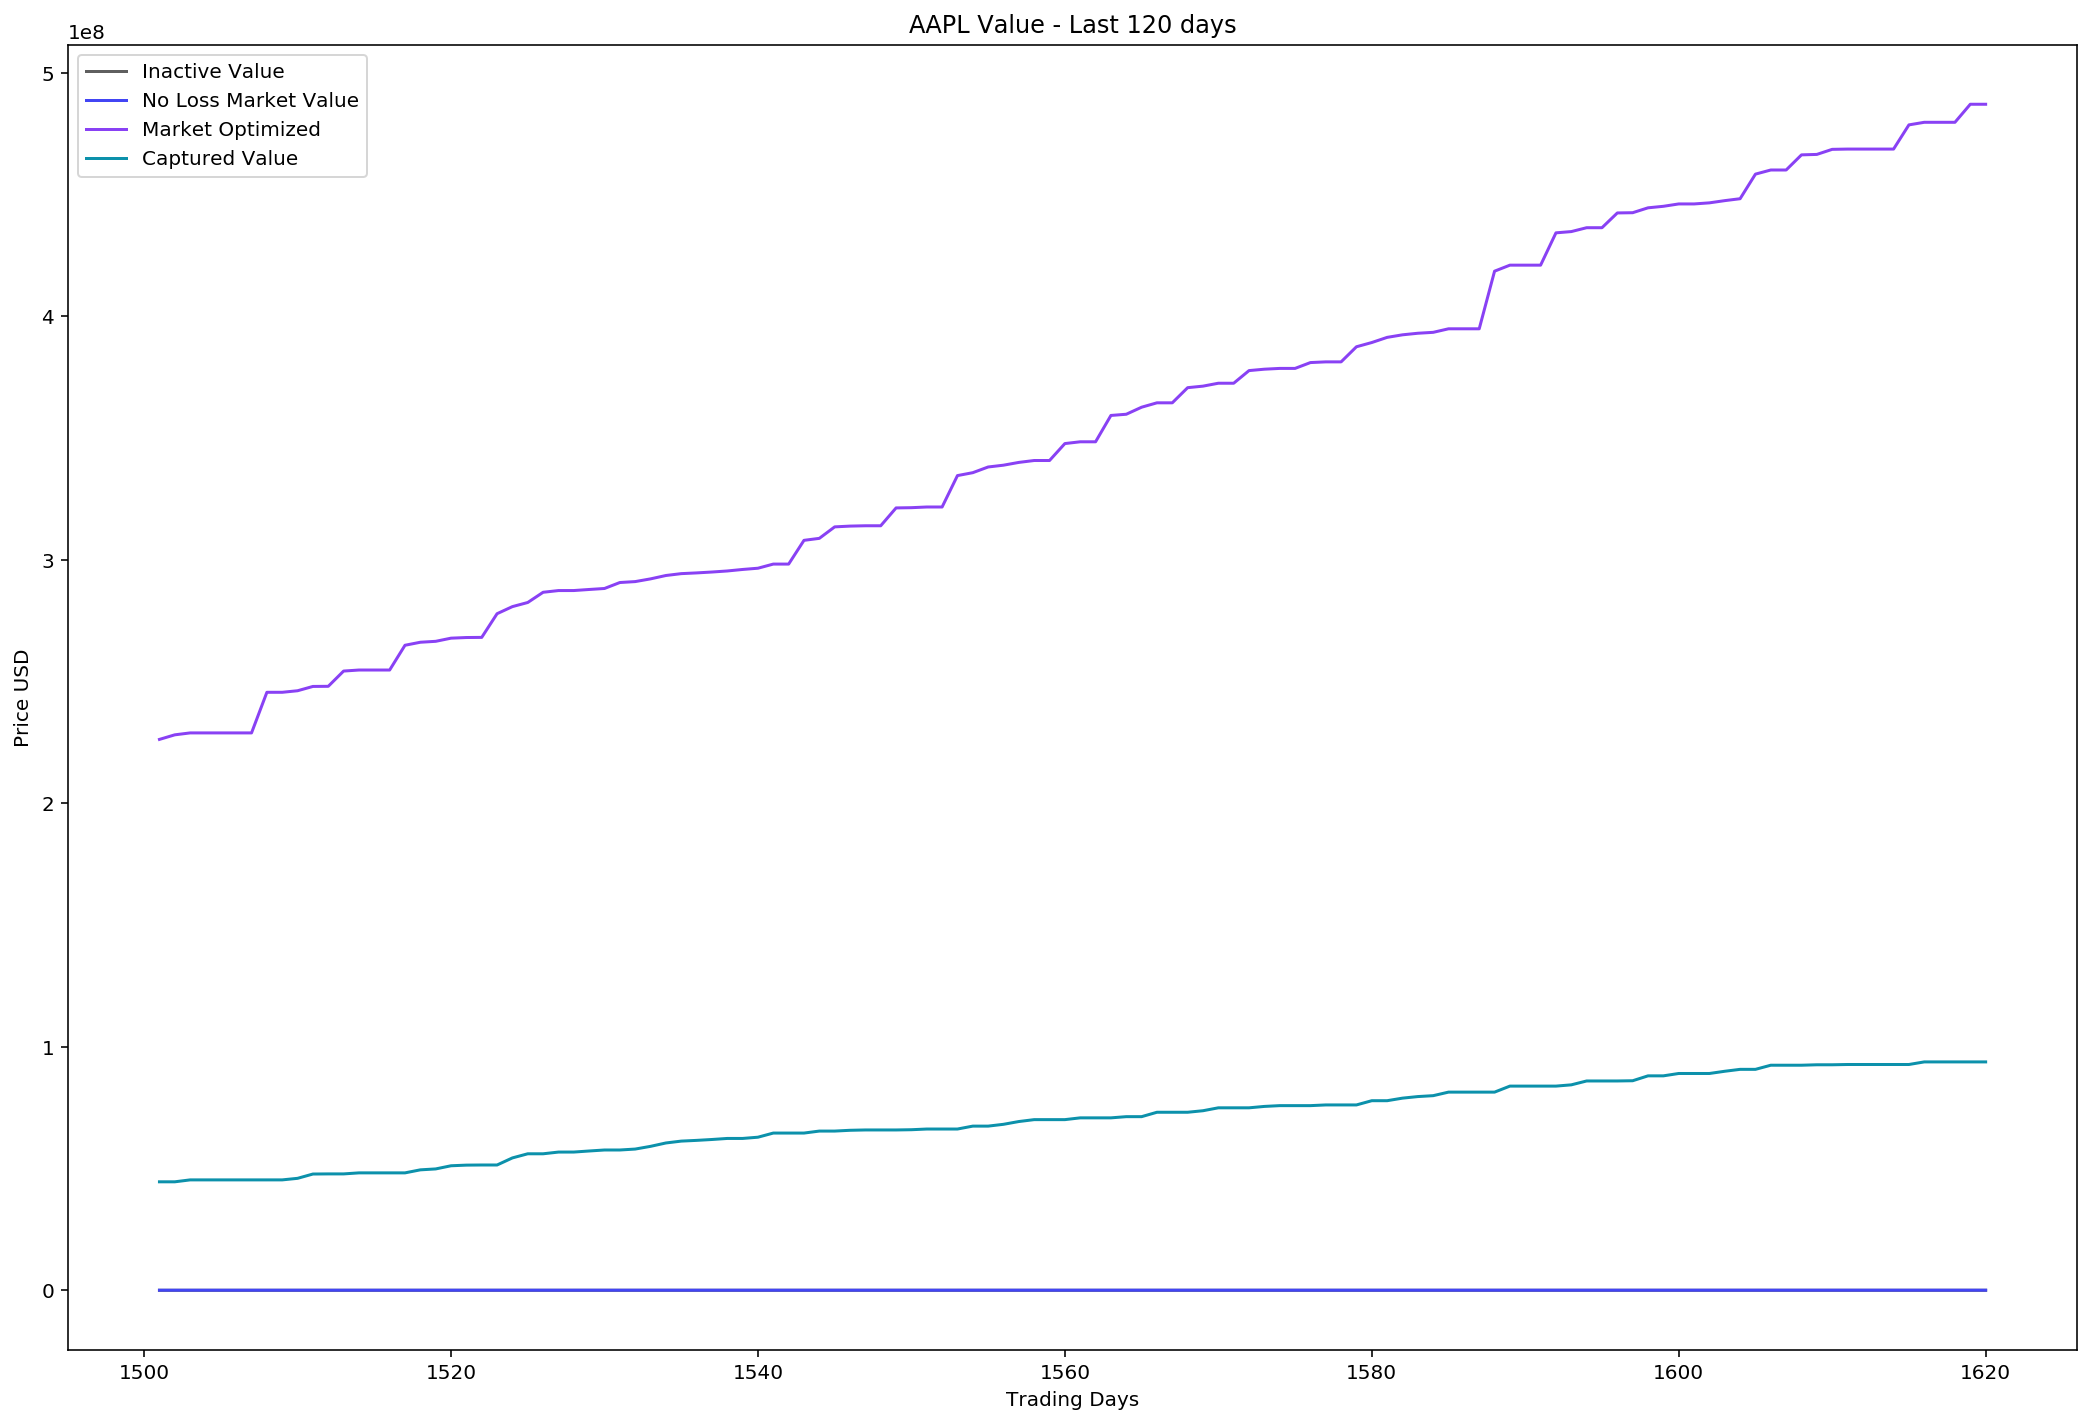

In [19]:
# Plot the stock price and captured value last 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[1621-120:,'InactiveValue'],'#5F5F5F', label='Inactive Value')
plt.plot(trades_df.loc[1621-120:,'NoLossMarketValue'], '#4245f4', label='No Loss Market Value')
plt.plot(trades_df.loc[1621-120:,'MarketOpt'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[1621-120:,'Folio'], '#0C91AB', label='Captured Value')

# Set title
ax.set_title(base_ticker + ' Value - Last 120 days')
ax.legend(loc='upper left')

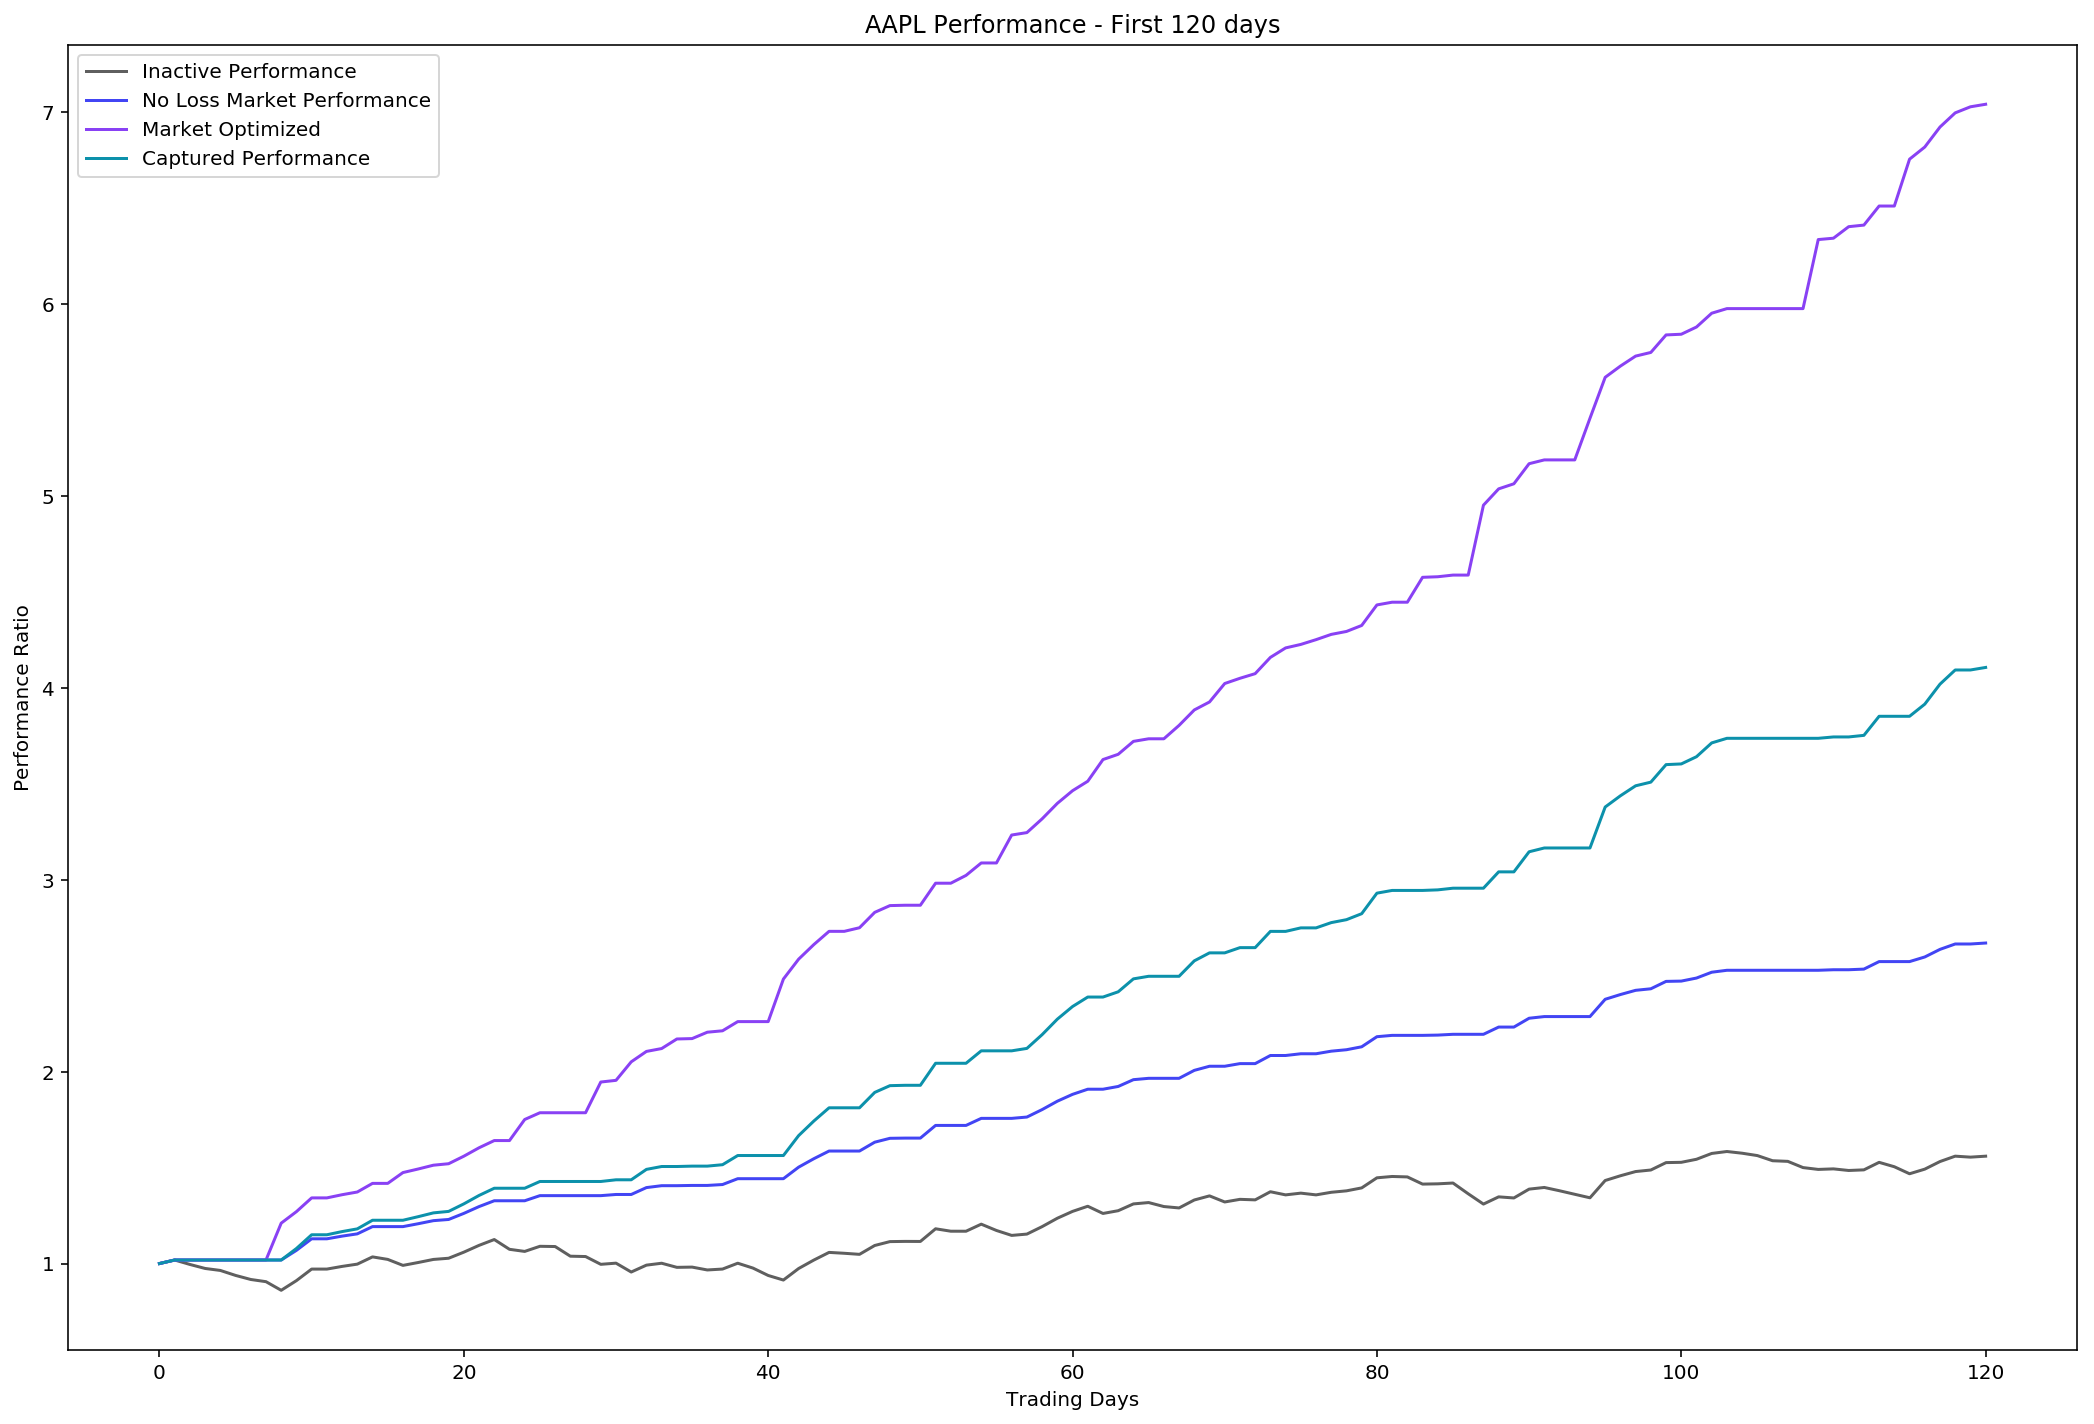

In [20]:
# Plot the performance metrics first 120 days (6 months of trading)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Performance Ratio')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(trades_df.loc[:120,'InactivePerform'],'#5F5F5F', label='Inactive Performance')
plt.plot(trades_df.loc[:120,'NoLossMarketPerform'], '#4245f4', label='No Loss Market Performance')
plt.plot(trades_df.loc[:120,'MarketOptPerform'], '#8941f4', label='Market Optimized')
plt.plot(trades_df.loc[:120,'Performance'], '#0C91AB', label='Captured Performance')

# Set title
ax.set_title(base_ticker + ' Performance - First 120 days')
ax.legend(loc='upper left')

# Log of Results:
Epochs: 5 Lookback: 1 

### SPY
Test Score: 0.000178 MSE (0.013357 RMSE)

Delta Price: 0.031085 - RMSE * Adjusted Close Range


### GE
Test Score: 0.000138 MSE (0.011735 RMSE)

Delta Price: 0.004274 - RMSE * Adjusted Close Range

### MSFT
Test Score: 0.000139 MSE (0.011771 RMSE)

Delta Price: 0.006115 - RMSE * Adjusted Close Range

### AAPL
Test Score: 0.000095 MSE (0.009769 RMSE)

Delta Price: 0.012173 - RMSE * Adjusted Close Range